In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx # to draw dags

# Lab 2 - Linear regressions, prior and posterior plots

 Linear Regressions

Today's tutorial will build upon our simulated frogs scenario and introduce some basic causal models and linear regressions.

## **Bayesian Workflow**

1.  Before fitting a model
    -   Define what we are estimating (Causal Structure)
    -   Choose an initial model / Model construction (lego blocks) / Start Simple
    -   Scale and transform data
    -   Prior predictive simulation
    -   Build generative model to simulate data
2.  Fitting the model
    -   Set initial values for priors
    -   Set chain parameters
    -   Fit the model
3.  Validating the models
    -   Use fake data simulation
4.  Addressing computation problems - not covered today
5.  Evaluate model fit
    -   Posterior predictive checks
    -   Plot out final linear regression
6.  Modifying the model
    -   Improve data model
    -   Incorporate additional data/predictors
    -   Refine priors distributions
7.  Compare models - not covered today

1.  Before fitting a model
    -   ***Define what we are estimating (Causal Structure)***

Last week, we went to a pond 30 times and recorded the presence/absence of frogs.
This time, let's imagine when we go to the pond and see frogs, we capture them, record their length, weight and sex then toss them back in.

While recording this data we notice that smaller frogs tend to weigh less than larger frogs, and we want to describe this relationship between weight and length.

**Q. How does length influence weight?**

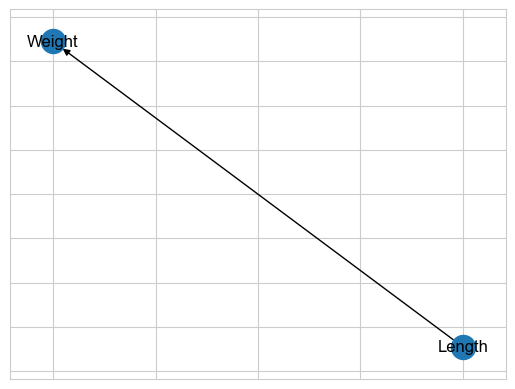

In [2]:
# causal model of our question
graph = nx.DiGraph()
graph.add_edges_from(
    [("Length", "Weight" )]
)
nx.draw_networkx(graph, arrows=True, pos=nx.spring_layout(graph))

It is important that we state our causal assumptions. Why is there an arrow going between Length and Weight? Here it is quite simple, as a frog gets longer it is reasonable to assume it also gets heavier.

What we are also implying in this causal model that:

**Weight is a function of Length**.

$$
Weight_i = \beta Length_i 
$$

But we know that weight is not just a function of Length, there are other factors that are unobserved that can influence weight

1.  Before fitting a model
    -   Define what we are estimating (Causal Structure)
    -   ***Choose an initial model / Model construction (lego blocks) / Start Simple***

In this step we want to start thinking about how we can build a statistical model to estimate the relationship between length and weight.
So the questions I start asking myself are.
- What distributions I want to use to represent my data likelihood and my priors?
- What kind of functional form do I want to use to represent the relationship between length and weight?
- It NEVER hurts to start simple.
So we start with a linear model and normal distribution.

$$
\large{
\begin{align*}
Weight_i \sim Normal(mu_i, sigma)\\
mu_i = alpha + \beta Length_i\\
alpha \sim Normal(0,1)\\
\beta \sim Normal(0,1)\\
sigma \sim Exp(1)
\end{align*}}
$$

1.  Before fitting a model
    -   Define what we are estimating (Causal Structure)
    -   Choose an initial model / Model construction (lego blocks) / Start Simple
    -   ***Scale and transform data***
    -   ***Prior predictive simulation***
    -   ***Build generative model to simulate data***

These next three steps are not always done in this order, but I find it useful to simulate data first, then standardize it, then do prior predictive simulation.
Once you are more familiar with building models you can usually jump straight to the last step, building a generative model, use that model to simulate data, and then do some prior predictive checks.

#### Simulate some data

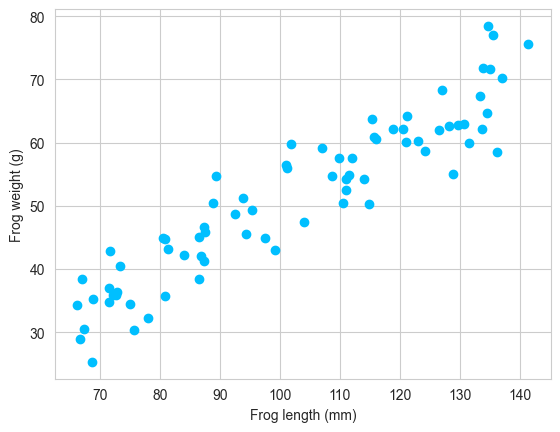

In [3]:
# number of frogs
n_frogs = 75

# linear model of lengths and weights.
def simulate_weight(lengths, sd, b):
    residual_variation = np.random.normal(0, sd, len(lengths))  # random noise
    weights = b*lengths + residual_variation
    return weights

# generate our frogs
lengths = np.random.uniform(65, 145, n_frogs)
weights = simulate_weight(lengths, sd=5, b=0.5)

# plot our data
plt.scatter(lengths, weights, color='deepskyblue')
plt.xlabel('Frog length (mm)')
plt.ylabel('Frog weight (g)')
plt.show()

#### Standardize data

Standardized data summary:
Length - Mean: -0.000, Std: 1.000
Weight - Mean: 0.000, Std: 1.000


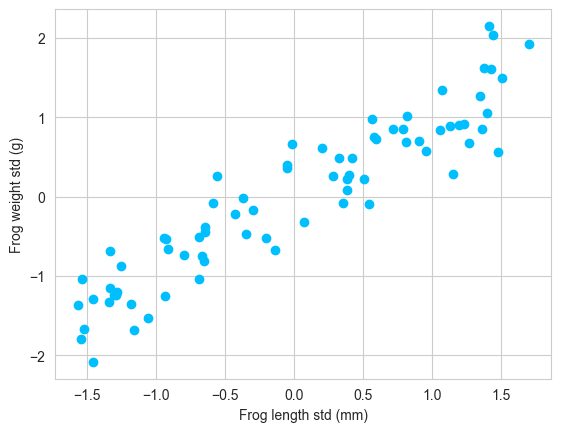

In [4]:
# package data and standardize
from scipy.stats import zscore

lengths_std = zscore(lengths)
weights_std = zscore(weights)

print("Standardized data summary:")
print(f"Length - Mean: {np.mean(lengths_std):.3f}, Std: {np.std(lengths_std):.3f}")
print(f"Weight - Mean: {np.mean(weights_std):.3f}, Std: {np.std(weights_std):.3f}")

plt.scatter(lengths_std, weights_std, color='deepskyblue')
plt.xlabel('Frog length std (mm)')
plt.ylabel('Frog weight std (g)')
plt.show()

#### Prior predictive simulation

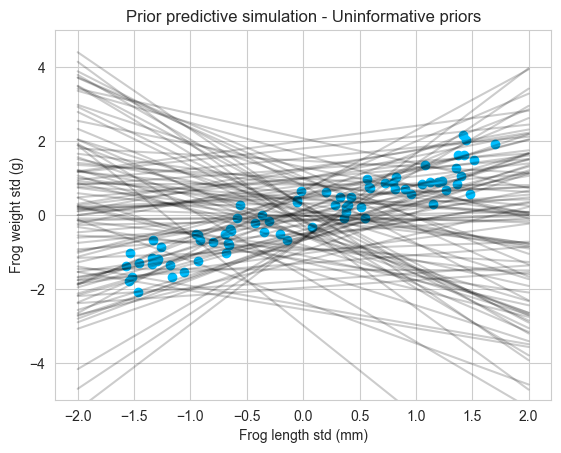

In [5]:
# simulate from our priors
n_samps = 100
alpha_prior = np.random.normal(0, 1, n_samps)
beta_prior = np.random.normal(0, 1, n_samps)

# plot 
plt.scatter(lengths_std, weights_std, color='deepskyblue', label='Data')
length_seq = np.linspace(-2, 2, 100)
for i in range(n_samps):
    plt.plot(length_seq, alpha_prior[i] + beta_prior[i]*length_seq, 'k-', alpha=0.2)
plt.xlabel('Frog length std (mm)')
plt.ylabel('Frog weight std (g)')
plt.ylim(-5, 5)
plt.title('Prior predictive simulation - Uninformative priors')
plt.show()

These priors are incredible uninformative, they predict both strongly positive and negative relationships, with values that are > -2,2 std deviations from the mean.
For now lets tighten these priors up by modifying the standard deviations.

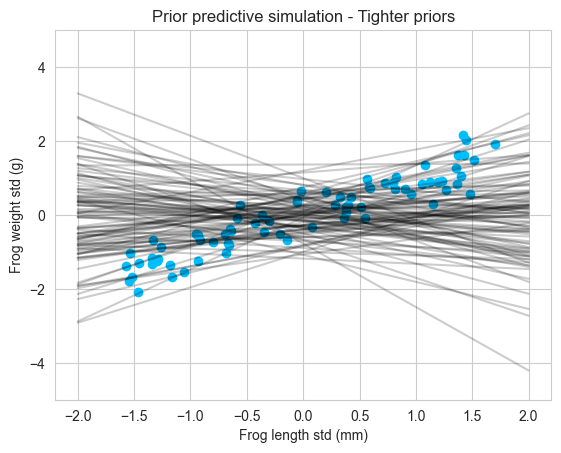

In [6]:
# simulate from our tighter priors
n_samps = 100
alpha_prior = np.random.normal(0, 0.5, n_samps)
beta_prior = np.random.normal(0, 0.5, n_samps)

# plot
plt.scatter(lengths_std, weights_std, color='deepskyblue', label='Data')
length_seq = np.linspace(-2, 2, 100)
for i in range(n_samps):
    plt.plot(length_seq, alpha_prior[i] + beta_prior[i]*length_seq, 'k-', alpha=0.2)
plt.xlabel('Frog length std (mm)')
plt.ylabel('Frog weight std (g)')
plt.ylim(-5, 5)
plt.title('Prior predictive simulation - Tighter priors')
plt.show()

2.  ***Fitting the model**
    -   Set initial values for priors
    -   Set chain parameters
    -   Fit the model

In [7]:
with pm.Model() as length_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + bL*lengths_std)
    
    # data likelihood
    weight = pm.Normal("weights", mu, sigma, observed=weights_std)
    
    length_idata = pm.sample(chains=4)

az.summary(length_idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bL, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.044,-0.080,0.083,0.001,0.001,5380.0,3073.0,1.0
bL,0.924,0.045,0.837,1.005,0.001,0.001,6237.0,3037.0,1.0
sigma,0.378,0.032,0.322,0.440,0.000,0.001,5182.0,2905.0,1.0
mu[0],1.335,0.079,1.187,1.479,0.001,0.001,5555.0,2658.0,1.0
mu[1],1.573,0.089,1.409,1.739,0.001,0.001,5637.0,2624.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[70],0.995,0.066,0.875,1.120,0.001,0.001,5422.0,2920.0,1.0
mu[71],0.506,0.051,0.409,0.597,0.001,0.001,5257.0,3191.0,1.0
mu[72],1.173,0.072,1.038,1.305,0.001,0.001,5496.0,3030.0,1.0
mu[73],-0.618,0.053,-0.715,-0.519,0.001,0.001,6021.0,3289.0,1.0


### 3. Validating the models
Did we get back what we put in?

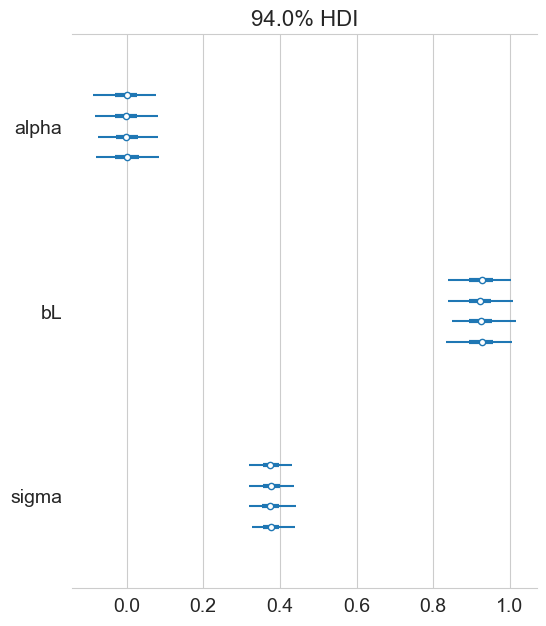

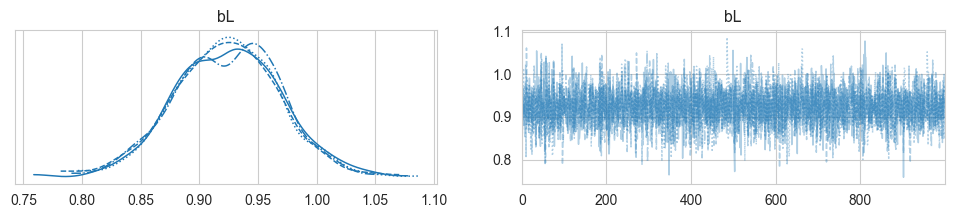

In [8]:
# forest plot
az.plot_forest(length_idata, var_names=['alpha', 'bL', 'sigma'])
plt.show()

# trace plot for bL
az.plot_trace(length_idata, var_names=['bL'])
plt.show()

Real-scale bL estimate: 0.504 ± 0.024


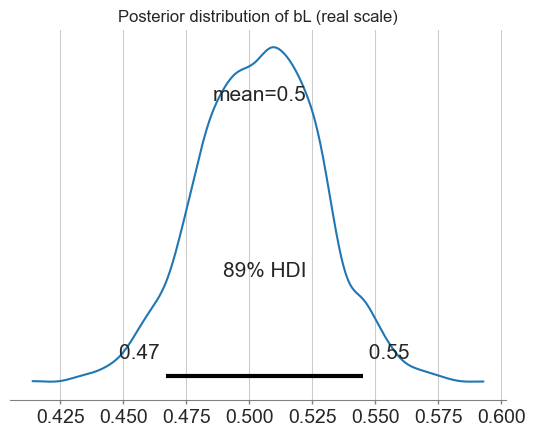

In [10]:
# function to backtransform our posterior estimates
def transform_posterior(idata, orig_weights, orig_lengths):
    posterior = idata.posterior
    bL_real = posterior['bL'] * np.std(orig_weights) / np.std(orig_lengths)
    return bL_real

# Apply transformation
bL_real = transform_posterior(length_idata, weights, lengths)

print(f"Real-scale bL estimate: {np.mean(bL_real):.3f} ± {np.std(bL_real):.3f}")

# plot posterior distribution of transformed bL
az.plot_posterior(bL_real, hdi_prob=0.89)
plt.title('Posterior distribution of bL (real scale)')
plt.show()

5.  Evaluate model fit
    -   ***Posterior predictive checks***
    -   ***Plot out final linear regression***

Here we check the predictions that are implied by our model against our data.
We do this to see if the model correctly approximated the posterior distribution and to gain insights into how the model fails.
Most often a model makes good predictions in some observations but not others.
We can then go and inspect those individual observations to get an idea of how to improve our model.
### Posterior predictive checks

### Plot out final linear regression

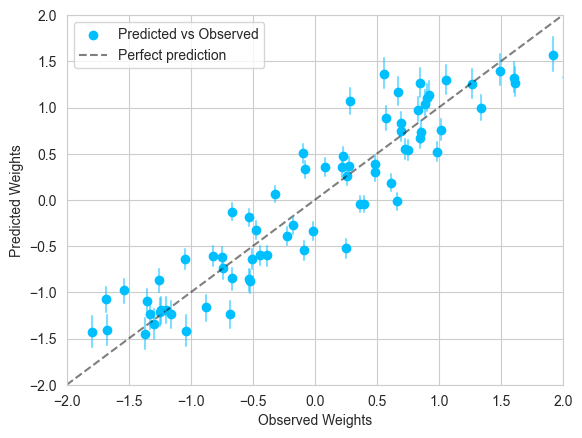

In [12]:
# compute the mean predicted by the model over the range of our data
mu_posterior = length_idata.posterior['mu']
mu_mean = mu_posterior.mean(dim=['chain', 'draw']).values
mu_hdi = az.hdi(mu_posterior, hdi_prob=0.96)['mu'].values

plt.scatter(weights_std, mu_mean, color='deepskyblue', label='Predicted vs Observed')
plt.plot([-2, 2], [-2, 2], 'k--', alpha=0.5, label='Perfect prediction')
for i in range(len(weights_std)):
    plt.plot([weights_std[i], weights_std[i]], [mu_hdi[i, 0], mu_hdi[i, 1]], 'deepskyblue', alpha=0.5)
plt.xlabel('Observed Weights')
plt.ylabel('Predicted Weights')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()
plt.show()

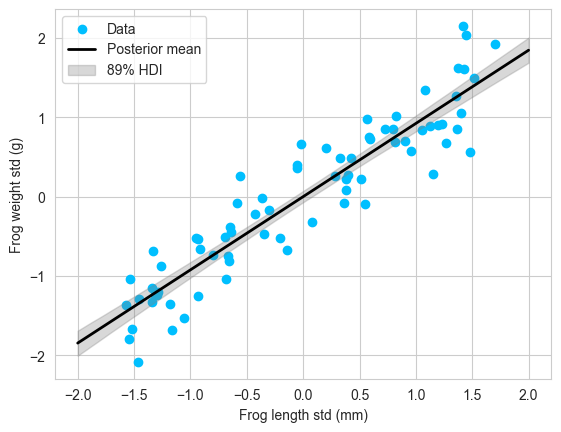

In [14]:
# extract samples from posterior
alpha_samples = length_idata.posterior['alpha']
bL_samples = length_idata.posterior['bL']

# generate a sequence of lengths to compute the posterior mean
lengths_seq = np.linspace(-2, 2, 100)

# compute posterior predictions
alpha_mean = alpha_samples.mean().values
bL_mean = bL_samples.mean().values
mu_line = alpha_mean + bL_mean * lengths_seq

# compute uncertainty intervals
mu_predictions = []
for length_val in lengths_seq:
    mu_pred = alpha_samples + bL_samples * length_val
    mu_predictions.append(mu_pred.values.flatten())

mu_predictions = np.array(mu_predictions)
mu_hdi = np.percentile(mu_predictions, [5.5, 94.5], axis=1)

plt.scatter(lengths_std, weights_std, color='deepskyblue', label='Data')
plt.plot(lengths_seq, mu_line, 'k-', linewidth=2, label='Posterior mean')
plt.fill_between(lengths_seq, mu_hdi[0], mu_hdi[1], alpha=0.3, color='gray', label='89% HDI')
plt.xlabel('Frog length std (mm)')
plt.ylabel('Frog weight std (g)')
plt.legend()
plt.show()

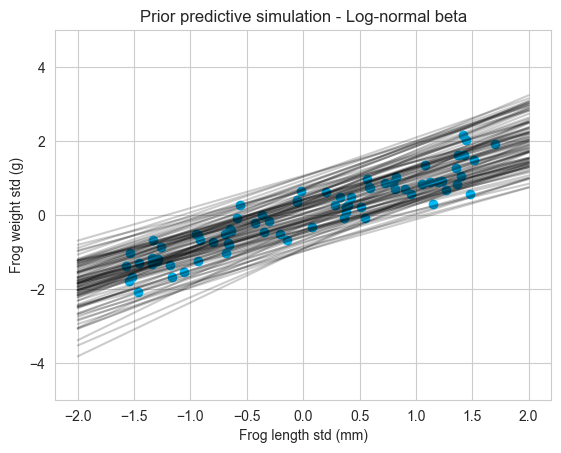

In [15]:
# prior predictive simulation with log-normal beta
alpha_prior = np.random.normal(0, 0.5, n_samps)
beta_prior = np.random.lognormal(0, 0.2, n_samps)

# plot
plt.scatter(lengths_std, weights_std, color='deepskyblue', label='Data')
for i in range(n_samps):
    plt.plot(length_seq, alpha_prior[i] + beta_prior[i]*length_seq, 'k-', alpha=0.2)
plt.xlabel('Frog length std (mm)')
plt.ylabel('Frog weight std (g)')
plt.ylim(-5, 5)
plt.title('Prior predictive simulation - Log-normal beta')
plt.show()

6.  Modifying the model
    -   ***Improve data model***
    -   ***Incorporate additional data/predictors***
    -   ***Refine priors distributions**

Priors should express scientific knowledge, but do so with some flexibility.
We know that generally weight increases with length.
So predicting negative relationships is not very useful.
So lets modify our prior on bL to be a log normal distribution.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bL, sigma]


Output()

/Users/aoakley/Library/Mobile Documents/com~apple~CloudDocs/Active_Projects/Dalhousie/AppliedBayes_2025/.venv/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Model 2 - Real-scale bL estimate: 0.509 ± 0.023


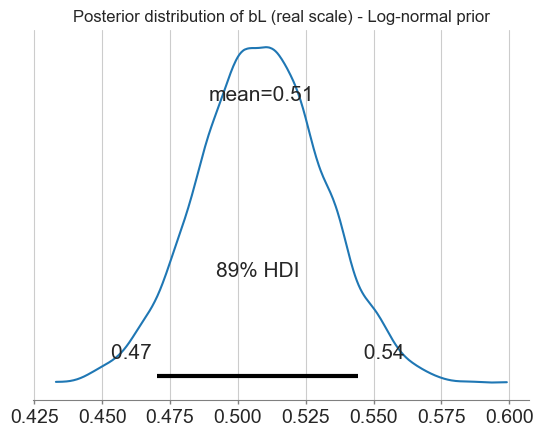

In [16]:
with pm.Model() as length_model_2:
    # priors
    alpha = pm.Normal("alpha", 0, 0.5)
    bL = pm.LogNormal("bL", 0, 0.2)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + bL*lengths_std)
    
    # data likelihood
    weight = pm.Normal("weights", mu, sigma, observed=weights_std)
    
    length_idata_2 = pm.sample(chains=4)

# transform posterior
bL_real_2 = transform_posterior(length_idata_2, weights, lengths)

print(f"Model 2 - Real-scale bL estimate: {np.mean(bL_real_2):.3f} ± {np.std(bL_real_2):.3f}")

# plot posterior distribution
az.plot_posterior(bL_real_2, hdi_prob=0.89)
plt.title('Posterior distribution of bL (real scale) - Log-normal prior')
plt.show()

## Multiple Linear Regression: Adding another covariate and spurious correlations

Let us add another covariate into our casual model. We are going to make this pretty far fetched to emphasize the points made in lecture of spurious correlation. Let's add colour into the mix!

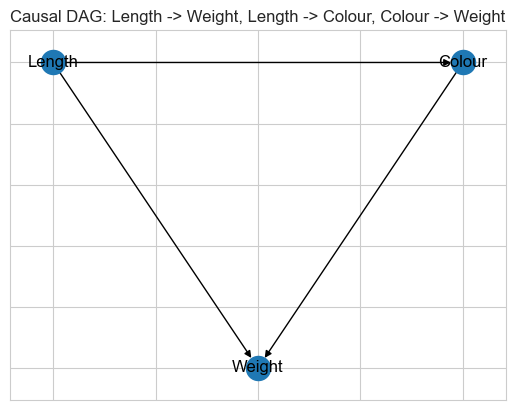

In [17]:
# causal model of our question
graph = nx.DiGraph()
graph.add_edges_from(
    [("Length", "Weight"), ("Length", "Colour"), ("Colour", "Weight")]
)
pos = {"Length": (0, 2), "Weight": (1, 1), "Colour": (2, 2)}
nx.draw_networkx(graph, arrows=True, pos=pos)
plt.title("Causal DAG: Length -> Weight, Length -> Colour, Colour -> Weight")
plt.show()

My causal assumptions stated in this model are

Length -> Weight: As a frog gets longer it gets heavier.

Length -> Colour: As a frog gets longer its colour changes.

Colour -> Weight: As a frog changes colour it also causes changes to weight ???

The functional implications of this causal model are:

$$
\large{
\begin{align*}
& Weight_i = \beta_L Length_i + \beta_C Colour_i \\
& Colour_i = \beta_{LC} Length_i\\
\end{align*}}
$$

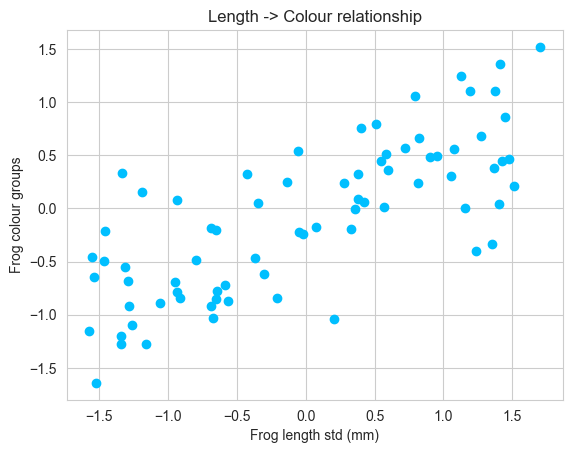

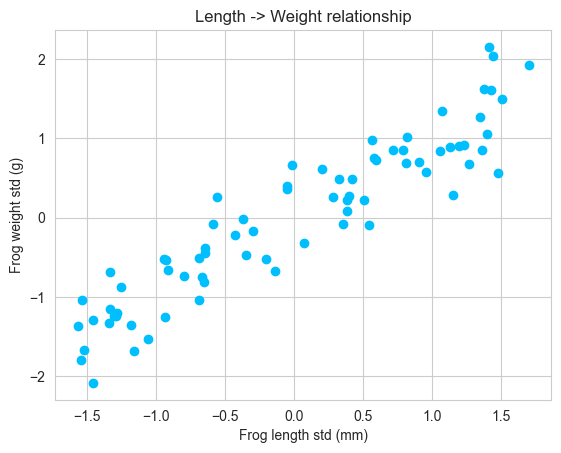

In [18]:
# We have our lengths and weights, so lets simulate the effect of length on colours
def simulate_colour(lengths, sd, b):
    residual_variation = np.random.normal(0, sd, len(lengths))  # random noise
    colour = b*lengths + residual_variation
    return colour

# generate our frogs colours
colours = simulate_colour(lengths_std, sd=0.5, b=0.6)

# our new relationship
plt.scatter(lengths_std, colours, color='deepskyblue')
plt.xlabel('Frog length std (mm)')
plt.ylabel('Frog colour groups')
plt.title('Length -> Colour relationship')
plt.show()

# our original 
plt.scatter(lengths_std, weights_std, color='deepskyblue')
plt.xlabel('Frog length std (mm)')
plt.ylabel('Frog weight std (g)')
plt.title('Length -> Weight relationship')
plt.show()

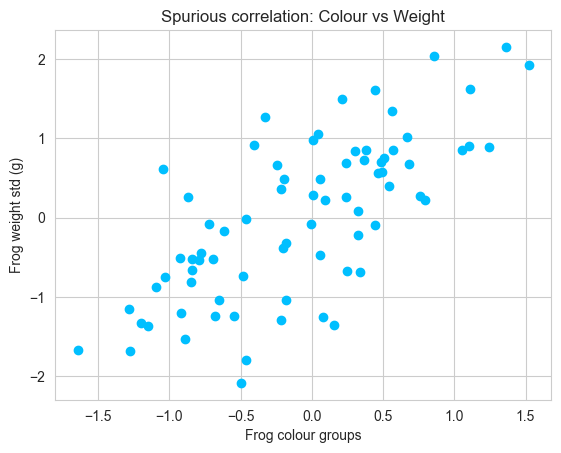

In [19]:
# here is the kicker, the relationship between weight and colour - even though we have never simulated any direct causal relationship between the two
plt.scatter(colours, weights_std, color='deepskyblue')
plt.xlabel('Frog colour groups')
plt.ylabel('Frog weight std (g)')
plt.title('Spurious correlation: Colour vs Weight')
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bC, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


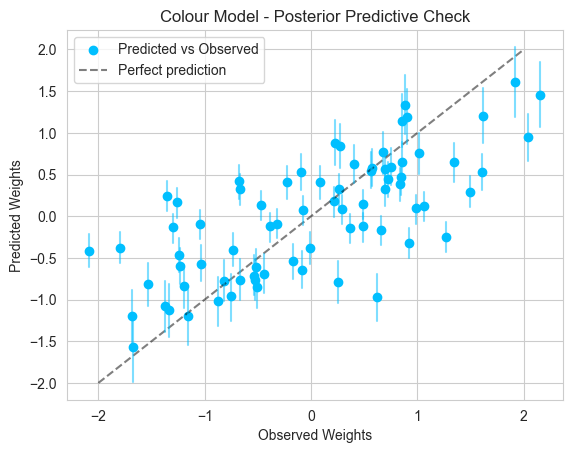

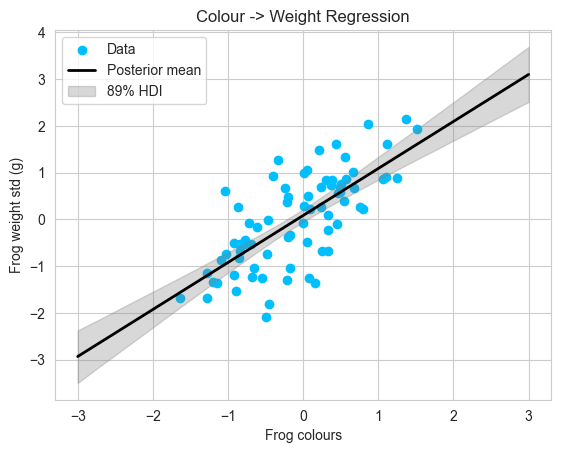

In [21]:
with pm.Model() as colour_model:
    # priors
    alpha = pm.Normal("alpha", 0, 1)
    bC = pm.LogNormal("bC", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + bC*colours)
    
    # data likelihood
    weight = pm.Normal("weights", mu, sigma, observed=weights_std)
    
    colour_idata = pm.sample(chains=4)

# posterior prediction plot 
mu_posterior = colour_idata.posterior['mu']
mu_mean = mu_posterior.mean(dim=['chain', 'draw']).values
mu_hdi = az.hdi(mu_posterior, hdi_prob=0.96)['mu'].values

plt.scatter(weights_std, mu_mean, color='deepskyblue', label='Predicted vs Observed')
plt.plot([-2, 2], [-2, 2], 'k--', alpha=0.5, label='Perfect prediction')
for i in range(len(weights_std)):
    plt.plot([weights_std[i], weights_std[i]], [mu_hdi[i, 0], mu_hdi[i, 1]], 'deepskyblue', alpha=0.5)
plt.xlabel('Observed Weights')
plt.ylabel('Predicted Weights')
plt.title('Colour Model - Posterior Predictive Check')
plt.legend()
plt.show()

# plot our regression
alpha_samples = colour_idata.posterior['alpha']
bC_samples = colour_idata.posterior['bC']

colours_seq = np.linspace(-3, 3, 100)
alpha_mean = alpha_samples.mean().values
bC_mean = bC_samples.mean().values
mu_line = alpha_mean + bC_mean * colours_seq

# compute uncertainty intervals
mu_predictions = []
for colour_val in colours_seq:
    mu_pred = alpha_samples + bC_samples * colour_val
    mu_predictions.append(mu_pred.values.flatten())

mu_predictions = np.array(mu_predictions)
mu_hdi = np.percentile(mu_predictions, [5.5, 94.5], axis=1)

plt.scatter(colours, weights_std, color='deepskyblue', label='Data')
plt.plot(colours_seq, mu_line, 'k-', linewidth=2, label='Posterior mean')
plt.fill_between(colours_seq, mu_hdi[0], mu_hdi[1], alpha=0.3, color='gray', label='89% HDI')
plt.xlabel('Frog colours')
plt.ylabel('Frog weight std (g)')
plt.title('Colour -> Weight Regression')
plt.legend()
plt.show()

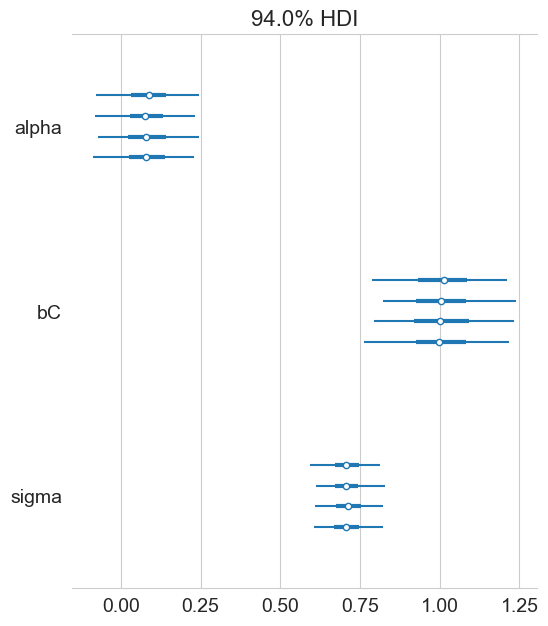

In [22]:
az.plot_forest(colour_idata, var_names=['alpha', 'bC', 'sigma'])
plt.show()

### Build our statistical model

$$
\large{
\begin{align*}
Weight_i \sim Normal(mu_i, sigma)\\
mu_i = alpha + \beta_L Length_i + \beta_C Colour_i\\
alpha \sim Normal(0,0.5)\\
\beta_L \sim Normal(0,0.2)\\
\beta_C \sim Normal(0,0.2)\\
sigma \sim Exp(1)
\end{align*}}
$$

#### Prior predictive simulation

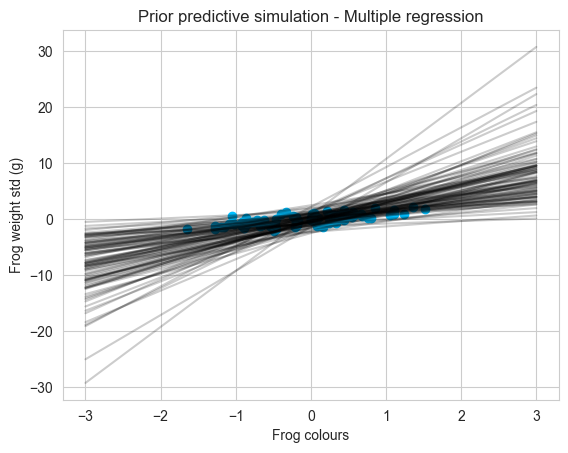

In [23]:
# simulate from our priors
n_samps = 100
alpha_prior = np.random.normal(0, 1, n_samps)
betaC_prior = np.random.lognormal(0, 0.8, n_samps)
betaL_prior = np.random.lognormal(0, 0.8, n_samps)

# plot 
plt.scatter(colours, weights_std, color='deepskyblue', label='Data')
for i in range(n_samps):
    colour_seq = np.linspace(-3, 3, 100)
    plt.plot(colour_seq, alpha_prior[i] + betaC_prior[i]*colour_seq + betaL_prior[i]*colour_seq, 'k-', alpha=0.2)
plt.xlabel('Frog colours')
plt.ylabel('Frog weight std (g)')
plt.title('Prior predictive simulation - Multiple regression')
plt.show()

Run our multiple regression

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bL, bC, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


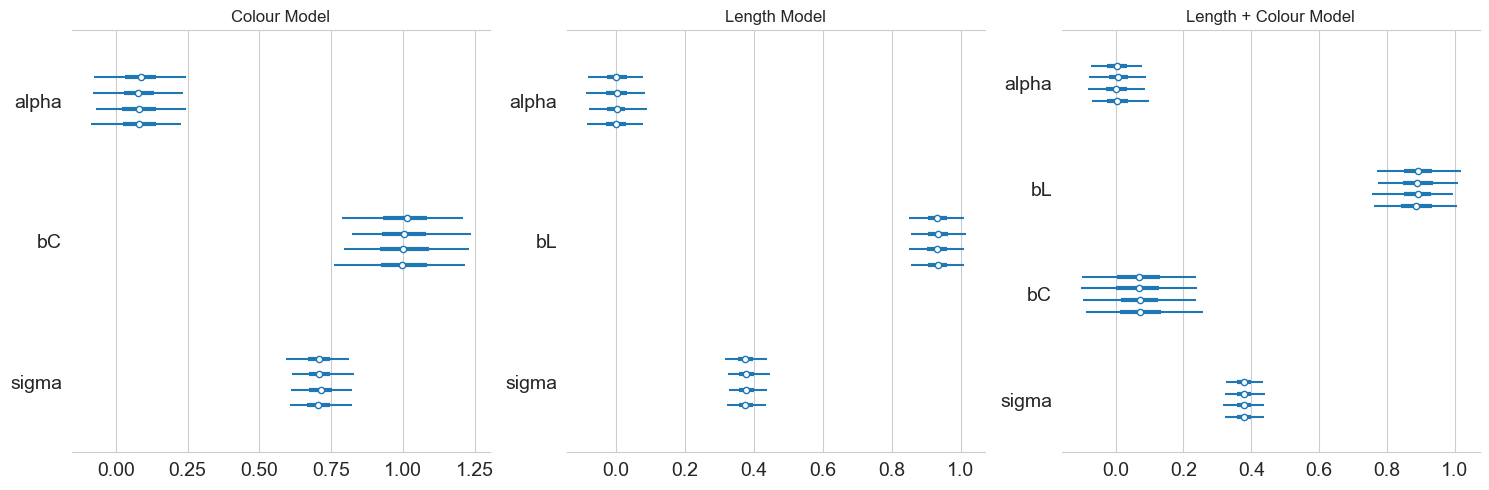

In [24]:
# multiple regression
with pm.Model() as length_colour_model:
    # priors
    alpha = pm.Normal("alpha", 0, 1)
    bL = pm.Normal("bL", 0, 0.8)
    bC = pm.Normal("bC", 0, 0.8)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + bL*lengths_std + bC*colours)
    
    # data likelihood
    weight = pm.Normal("weights", mu, sigma, observed=weights_std)
    
    length_colour_idata = pm.sample(chains=4)

az.summary(length_colour_idata)

# Using forest plots we can plot what each parameter estimate is for each model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

az.plot_forest(colour_idata, var_names=['alpha', 'bC', 'sigma'], ax=axes[0])
axes[0].set_title('Colour Model')

az.plot_forest(length_idata_2, var_names=['alpha', 'bL', 'sigma'], ax=axes[1])
axes[1].set_title('Length Model')

az.plot_forest(length_colour_idata, var_names=['alpha', 'bL', 'bC', 'sigma'], ax=axes[2])
axes[2].set_title('Length + Colour Model')

plt.tight_layout()
plt.show()

When plotting the effect sizes of each of the beta parameters we can see the bC effect drop off completely.

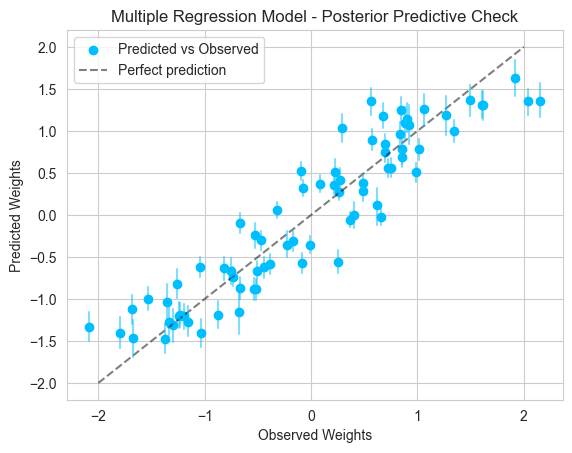

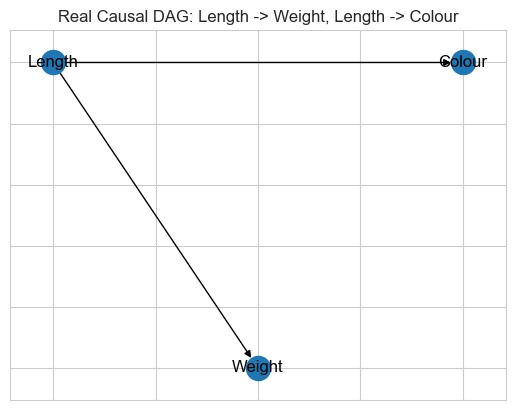

In [25]:
# posterior prediction plot 
mu_posterior = length_colour_idata.posterior['mu']
mu_mean = mu_posterior.mean(dim=['chain', 'draw']).values
mu_hdi = az.hdi(mu_posterior, hdi_prob=0.96)['mu'].values

plt.scatter(weights_std, mu_mean, color='deepskyblue', label='Predicted vs Observed')
plt.plot([-2, 2], [-2, 2], 'k--', alpha=0.5, label='Perfect prediction')
for i in range(len(weights_std)):
    plt.plot([weights_std[i], weights_std[i]], [mu_hdi[i, 0], mu_hdi[i, 1]], 'deepskyblue', alpha=0.5)
plt.xlabel('Observed Weights')
plt.ylabel('Predicted Weights')
plt.title('Multiple Regression Model - Posterior Predictive Check')
plt.legend()
plt.show()

# real causal model
graph = nx.DiGraph()
graph.add_edges_from(
    [("Length", "Weight"), ("Length", "Colour")]
)
pos = {"Length": (0, 2), "Weight": (1, 1), "Colour": (2, 2)}
nx.draw_networkx(graph, arrows=True, pos=pos)
plt.title("Real Causal DAG: Length -> Weight, Length -> Colour")
plt.show()